### This jupyter notebook continues the analysis from calculate_DockQ_between_predicted_models to address the comment from Reviewer #1.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import db_utils
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2/'

In [2]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [3]:
# get prediction names and ranked_0 DockQ measured against template model from MySQL DB
query = """select prediction_name, DockQ as DockQ_ranked_0_to_template from chopyan_db.AlphaFold_prediction_result
where run_id = 'run37' and project_name = 'AlphaFold_benchmark' and model_id = 'ranked_0';"""
ranked_0_df = pd.read_sql_query(query,con=connect)

# since ranked_0 is not necesarily the best model (model with max DockQ)
# get prediction names and the max DockQ measured from all predicted model against template model from MySQL DB
query = """select prediction_name, max(DockQ) as max_DockQ_to_template from chopyan_db.AlphaFold_prediction_result
where run_id = 'run37' and project_name = 'AlphaFold_benchmark'
group by prediction_name;"""
max_DockQ_df = pd.read_sql_query(query,con=connect)

# read in the DockQ calculated between all combinations of AlphaFold predicted models
PRS_df = pd.read_csv('/Users/chopyanlee/AlphaFold_benchmark/DockQ_between_models_run37.tsv',sep='\t',
                index_col=0)

# read in the DockQ calculated between all combinations of AlphaFold predicted RRS models
RRS_df = pd.read_csv('/Users/chopyanlee/AlphaFold_benchmark/DockQ_between_models_run38.tsv',sep='\t',
                index_col=0)

In [4]:
ranked_0_df

,prediction_name,DockQ_ranked_0_to_template
0,run37_DEG_APCC_KENBOX_2_4GGD,0.878
1,run37_DEG_COP1_1_5IGO,0.203
2,run37_DEG_Kelch_Keap1_1_2FLU,0.957
3,run37_DEG_Kelch_Keap1_2_3WN7,0.628
4,run37_DEG_MDM2_SWIB_1_1YCR,0.928
...,...,...
131,run37_TRG_ER_FFAT_1_2RR3,0.832
132,run37_TRG_LysEnd_GGAAcLL_1_1JWG,0.950
133,run37_TRG_NES_CRM1_1_3GB8,0.683
134,run37_TRG_NLS_Bipartite_1_1PJM,0.838


In [5]:
max_DockQ_df

,prediction_name,max_DockQ_to_template
0,run37_DEG_APCC_KENBOX_2_4GGD,0.883
1,run37_DEG_COP1_1_5IGO,0.305
2,run37_DEG_Kelch_Keap1_1_2FLU,0.978
3,run37_DEG_Kelch_Keap1_2_3WN7,0.660
4,run37_DEG_MDM2_SWIB_1_1YCR,0.928
...,...,...
131,run37_TRG_ER_FFAT_1_2RR3,0.833
132,run37_TRG_LysEnd_GGAAcLL_1_1JWG,0.950
133,run37_TRG_NES_CRM1_1_3GB8,0.683
134,run37_TRG_NLS_Bipartite_1_1PJM,0.839


In [6]:
agg_df = PRS_df.groupby('prediction_name').agg({'DockQ':[('DockQ_between_models_std','std'),
                                                     ('DockQ_between_models_mean','mean')]})
agg_df

DockQ  \
                                DockQ_between_models_std   
prediction_name                                            
run37_DEG_APCC_KENBOX_2_4GGD                    0.262713   
run37_DEG_COP1_1_5IGO                           0.193281   
run37_DEG_Kelch_Keap1_1_2FLU                    0.157271   
run37_DEG_Kelch_Keap1_2_3WN7                    0.045470   
run37_DEG_MDM2_SWIB_1_1YCR                      0.091376   
...                                                  ...   
run37_TRG_ER_FFAT_1_2RR3                        0.004280   
run37_TRG_LysEnd_GGAAcLL_1_1JWG                 0.038199   
run37_TRG_NES_CRM1_1_3GB8                       0.354208   
run37_TRG_NLS_Bipartite_1_1PJM                  0.097730   
run37_TRG_PTS1_2C0L                             0.006488   

                                                           
                                DockQ_between_models_mean  
prediction_name                                            
run37_DEG_APCC_KENBOX_2_4GGD                       0.6130  
run37_DEG_COP1_1_5IGO                              0.7872  
run37_DEG_Kelch_Keap1_1_2FLU                       0.8642  
run37_DEG_Kelch_Keap1_2_3WN7                       0.8408  
run37_DEG_MDM2_SWIB_1_1YCR                         0.9217  
...                                                   ...  
run37_TRG_ER_FFAT_1_2RR3                           0.9881  
run37_TRG_LysEnd_GGAAcLL_1_1JWG                    0.8595  
run37_TRG_NES_CRM1_1_3GB8                          0.5790  
run37_TRG_NLS_Bipartite_1_1PJM                     0.8419  
run37_TRG_PTS1_2C0L                                0.9949  

[136 rows x 2 columns]

In [7]:
final_df = agg_df['DockQ'].reset_index().merge(ranked_0_df)
final_df = final_df.merge(max_DockQ_df)
final_df

,prediction_name,DockQ_between_models_std,DockQ_between_models_mean,DockQ_ranked_0_to_template,max_DockQ_to_template
0,run37_DEG_APCC_KENBOX_2_4GGD,0.262713,0.6130,0.878,0.883
1,run37_DEG_COP1_1_5IGO,0.193281,0.7872,0.203,0.305
2,run37_DEG_Kelch_Keap1_1_2FLU,0.157271,0.8642,0.957,0.978
3,run37_DEG_Kelch_Keap1_2_3WN7,0.045470,0.8408,0.628,0.660
4,run37_DEG_MDM2_SWIB_1_1YCR,0.091376,0.9217,0.928,0.928
...,...,...,...,...,...
131,run37_TRG_ER_FFAT_1_2RR3,0.004280,0.9881,0.832,0.833
132,run37_TRG_LysEnd_GGAAcLL_1_1JWG,0.038199,0.8595,0.950,0.950
133,run37_TRG_NES_CRM1_1_3GB8,0.354208,0.5790,0.683,0.683
134,run37_TRG_NLS_Bipartite_1_1PJM,0.097730,0.8419,0.838,0.839


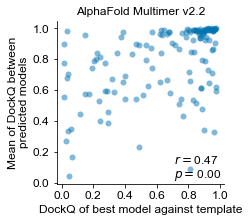

In [9]:
# plot a scatterplot of the two metrics' correlation
cor = sp.pearsonr(final_df['DockQ_ranked_0_to_template'],final_df['DockQ_between_models_mean'])

fig,ax = plt.subplots(figsize=figsize)
plt.scatter(x=final_df['DockQ_ranked_0_to_template'],y=final_df['DockQ_between_models_mean'],alpha=0.5,linewidths=0)

modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2, y_major_multiple=0.2, y_minor_multiple=0.2)
plt.setp(ax.xaxis.get_ticklines(), 'visible', True)
ax.tick_params(top=False)
plt.ylabel('Mean of DockQ between\npredicted models', fontsize=global_fontsize)
plt.xlabel('DockQ of best model against template', fontsize=global_fontsize)
plt.text(0.7,0.04,transform=plt.gca().transAxes,s=r'$r = $' + f'{cor[0]:.2f}' + '\n' + r'$p = $' + f'{cor[1]:.2f}',
         fontsize=global_fontsize)
ax.set_title('AlphaFold Multimer v2.2',fontsize=global_fontsize)

plt.savefig(f'{save_path}mean_DockQ_between_models_DockQ_best_model_against_template_scatterplot.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}mean_DockQ_between_models_DockQ_best_model_against_template_scatterplot.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

In [10]:
PRS_agg_df = PRS_df.groupby('prediction_name').agg({'DockQ':[('DockQ_between_models_std','std'),
                                                     ('DockQ_between_models_mean','mean')]})
PRS_agg_df = PRS_agg_df['DockQ'].reset_index()
PRS_agg_df['label'] = 1
RRS_agg_df = RRS_df.groupby('prediction_name').agg({'DockQ':[('DockQ_between_models_std','std'),
                                                     ('DockQ_between_models_mean','mean')]})
RRS_agg_df = RRS_agg_df['DockQ'].reset_index()
RRS_agg_df['label'] = 0
PRS_RRS_df = pd.concat([PRS_agg_df,RRS_agg_df],axis=0,ignore_index=True)
PRS_RRS_df

,prediction_name,DockQ_between_models_std,DockQ_between_models_mean,label
0,run37_DEG_APCC_KENBOX_2_4GGD,0.262713,0.6130,1
1,run37_DEG_COP1_1_5IGO,0.193281,0.7872,1
2,run37_DEG_Kelch_Keap1_1_2FLU,0.157271,0.8642,1
3,run37_DEG_Kelch_Keap1_2_3WN7,0.045470,0.8408,1
4,run37_DEG_MDM2_SWIB_1_1YCR,0.091376,0.9217,1
...,...,...,...,...
267,run38_MTRG_ER_FFAT_1_2RR3.DDOC_MAPK_HePTP_8_2GPH,0.082741,0.8323,0
268,run38_MTRG_LysEnd_GGAAcLL_1_1JWG.DLIG_SUMO_SIM...,0.388107,0.5205,0
269,run38_MTRG_NES_CRM1_1_3GB8.DDOC_PP1_MyPhoNE_1_...,0.237307,0.3380,0
270,run38_MTRG_NLS_Bipartite_1_1PJM.DLIG_PDZ_Class...,0.298805,0.2357,0


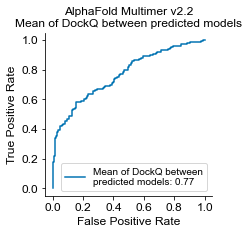

In [13]:
fpr, tpr, thresholds = roc_curve(PRS_RRS_df['label'],PRS_RRS_df['DockQ_between_models_mean'])

fig,ax = plt.subplots(figsize=figsize)
ax.plot(fpr,tpr,label=f'Mean of DockQ between\npredicted models: {auc(fpr,tpr):.2f}',color=f'C0')
ax.set_xlabel('False Positive Rate', fontsize=global_fontsize)
ax.set_ylabel('True Positive Rate', fontsize=global_fontsize)
modify_ticks_and_labels(ax=ax,y_major_multiple=0.2,y_minor_multiple=0.2,
                        x_major_multiple=0.2,x_minor_multiple=0.2)
ax.set_title('AlphaFold Multimer v2.2\nMean of DockQ between predicted models',fontsize=global_fontsize)
ax.legend(loc='lower right')

plt.savefig(f'/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/mut_rand_min_ext_DMI/MMv2.2/min_PRS_RRS_mean_DockQ_between_models_ROC.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/mut_rand_min_ext_DMI/MMv2.2/min_PRS_RRS_mean_DockQ_between_models_ROC.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='DockQ_between_models_mean', ylabel='Count'>

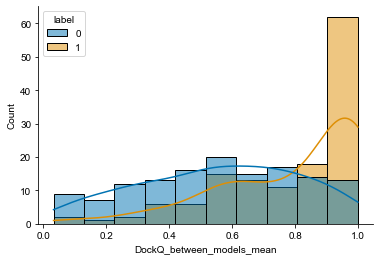

In [15]:
sns.histplot(data=PRS_RRS_df,x='DockQ_between_models_mean',kde=True,hue='label')